# Notebook for reproducing Fig 6a and Fig S9

In [1]:
import numpy as np
from shapely.geometry import box
from mbhl.simulation import Mask, Physics, System, Circle, Rectangle, Square
from mbhl.simulation import nm, um
import matplotlib.pyplot as plt
import figurefirst as ff
from pathlib import Path

In [2]:
%mkdir -p subfigs-Fig6

Below are the angle depositions for square and hexagonal lattice nanoapertures

In [7]:
def plot_two_angle_deposition_square(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H = 5 * um,
    diffusion=15 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    # lim=(0.5 * um, 7.5 * um, 0.5 * um, 7.5 * um),
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=2,
    angle_offset=30,
):
    # We always show 8 x 8 superlattice
    radius = L * rl_ratio
    # radius = diameter / 2
    # H = gap
    R = L * Rl_ratio
    psi = np.arctan(R / H / 2)

    n_pts = n_pts
    angle_offset = theta
    trajectory = np.array(
        [(psi, theta) for theta in np.deg2rad(np.linspace(angle_offset + 0, angle_offset + 360, n_pts + 1))[:-1]]
    )
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    W = L
    pos = [Circle(0, 0, radius), ]
    cell = (W, W)
    mask = Mask(
        pos,
        unit_cell=cell,
        repeat=(10, 10),
        pad=50 * nm,
        thickness=0 * nm,
        spacing=H,
    )
    system = System(mask=mask, physics=phys)
    conv = system.simulate(h=default_h / h_ratio)
    if ax:
        ax.set_axis_off()
        system.draw(
            ax,
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            xlim=[W, 9 * W],
            ylim=[W, 9 * W],
            alpha=alpha,
            # vmax=200 / n_pts
        )
    return system

In [8]:
def plot_two_angle_deposition_hex(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H = 5 * um,
    diffusion=15 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    # lim=(0.5 * um, 7.5 * um, 0.5 * um, 7.5 * um),
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=2,
    angle_offset=30,
):
    # We always show 8 x 8 superlattice
    radius = L * rl_ratio
    # radius = diameter / 2
    # H = gap
    R = L * Rl_ratio
    psi = np.arctan(R / H / 2)

    n_pts = n_pts
    angle_offset = theta
    trajectory = np.array(
        [(psi, theta) for theta in np.deg2rad(np.linspace(angle_offset + 0, angle_offset + 360, n_pts + 1))[:-1]]
    )
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    W = L
    pos = [Circle(0, 0, radius), 
           Circle(W / 2, W * np.sqrt(3) / 2, radius)]
    cell = (W, W * np.sqrt(3))
    mask = Mask(
        pos,
        unit_cell=cell,
        repeat=(10, 10),
        pad=50 * nm,
        thickness=0 * nm,
        spacing=H,
    )
    system = System(mask=mask, physics=phys)
    conv = system.simulate(h=default_h / h_ratio)
    if ax:
        ax.set_axis_off()
        system.draw(
            ax,
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            xlim=[W, 9 * W],
            ylim=[W, 9 * W],
            alpha=alpha,
            # vmax=200 / n_pts
        )
    return system

## Example of n=2 on hexagonal lattice 

(1726, 1030)


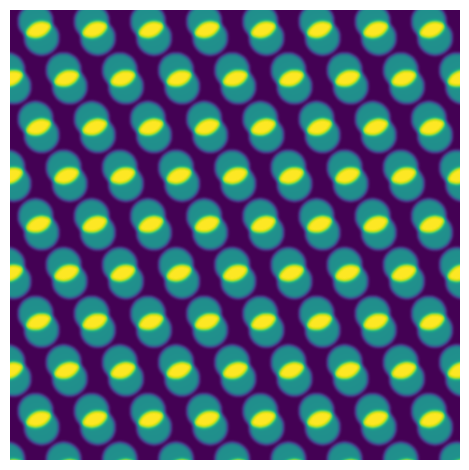

In [9]:
# 0D-hex
system = plot_two_angle_deposition_hex(plt.gca(),
                          rl_ratio=0.3,
                          Rl_ratio=0.3,
                          theta=22.5, 
                          default_h=5 * nm,
                          n_pts=2,
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-hex-0.3-0.3.png")

(1736, 1040)


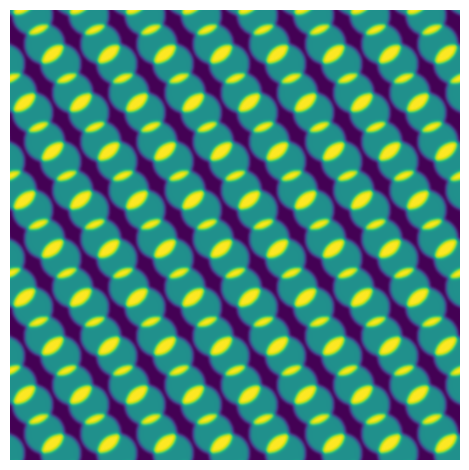

In [10]:
# 1d-hex
system = plot_two_angle_deposition_hex(plt.gca(),
                          rl_ratio=0.35,
                          Rl_ratio=0.55,
                          theta=22.5, 
                          default_h=5 * nm,
                          n_pts=2,
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-hex-0.35-0.55.png")

(1756, 1060)


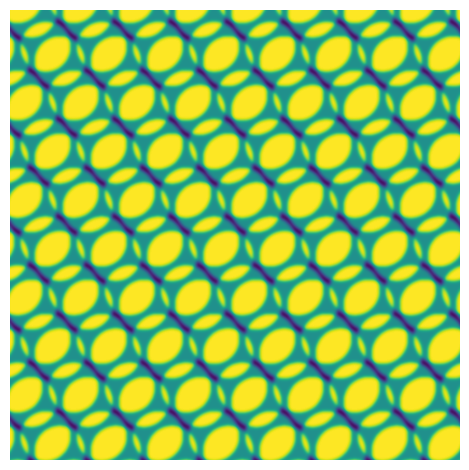

In [11]:
# 2d-hex
system = plot_two_angle_deposition_hex(plt.gca(),
                          rl_ratio=0.45,
                          Rl_ratio=0.65,
                          theta=22.5, 
                          default_h=5 * nm,
                          n_pts=2,
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-hex-0.45-0.65.png")

## Below are examples of n=2 on square lattice

(980, 980)


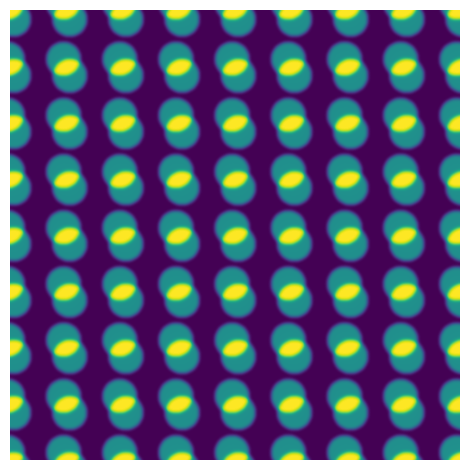

In [12]:
#### 0d on square
plot_two_angle_deposition_square(plt.gca(),
                          rl_ratio=0.3,
                          Rl_ratio=0.3,
                          theta=22.5, 
                          default_h=5 * nm, 
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-0.3-0.3.png")

(1000, 1000)


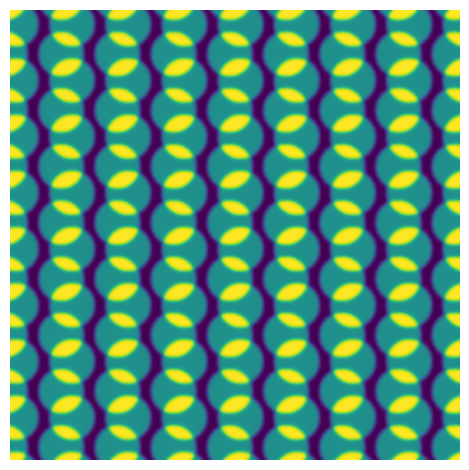

In [14]:
#1d on square
plot_two_angle_deposition_square(plt.gca(),
                          rl_ratio=0.40,
                          Rl_ratio=0.5,
                          theta=22.5, 
                          default_h=5 * nm, 
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-0.4-0.5.png")

(1020, 1020)


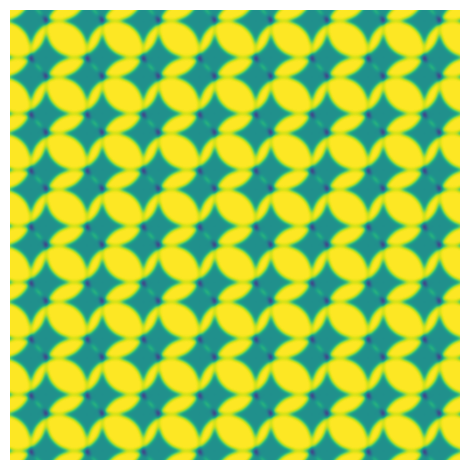

In [15]:
#2d on square
plot_two_angle_deposition_square(plt.gca(),
                          rl_ratio=0.50,
                          Rl_ratio=0.70,
                          theta=22.5, 
                          default_h=5 * nm, 
                          # lim=(0.5 * um, 5.5 * um, 0.5 * um, 5.5 * um),
                         )
plt.tight_layout()
plt.savefig("subfigs-Fig6/2pts-0.5-0.7.png")

## Use dimensionality algorithm for atomistic structures to determine phase diagram


In [16]:
import ase
from ase.data import covalent_radii
from ase.data import atomic_names, atomic_numbers
from ase.atoms import Atoms
from ase.geometry.dimensionality import isolate_components
from pathlib import Path

In [17]:
def generate_fake_atoms(rl_ratio=0.25, Rl_ratio=0.5, 
                        theta=0.0,
                        symbol="X", 
                        default_r=covalent_radii[0],
                       lattice="square"):
    pbc = [True, True, False]
    L = default_r / rl_ratio
    R = L * Rl_ratio
    if lattice == "square":
        cell = [L, L, 0]
        theta = 90 - theta
        px, py = R * np.cos(np.deg2rad(theta)), R * np.sin(np.deg2rad(theta))
        positions = [[0, 0, 0],
                    [px, py, 0]]
        atoms = Atoms("X2", positions=positions, cell=cell, pbc=pbc)
    elif lattice == "hex":
        cell = [L, L * 3 ** 0.5, 0]
        theta = 90 - theta
        px, py = R * np.cos(np.deg2rad(theta)), R * np.sin(np.deg2rad(theta))
        positions = [[0, 0, 0],
                     [L / 2, L / 2 * 3 ** 0.5, 0],
                    [px, py, 0],
                     [L / 2 + px, L / 2 * 3 ** 0.5 + py, 0]
                    ]
        atoms = Atoms("X4", positions=positions, cell=cell, pbc=pbc)
    else:
        raise NotImplementedError()
    return atoms

In [18]:
def pattern_dimensionality(rl_ratio=0.25, Rl_ratio=0.5, theta=0.0, lattice="square"):
    atoms = generate_fake_atoms(rl_ratio, Rl_ratio, theta, lattice=lattice)
    comp = isolate_components(atoms, kcutoff=1.05)
    return int(list(comp.keys())[0][0])

First we plot the square lattice using a finer mesh (200 in each direction)

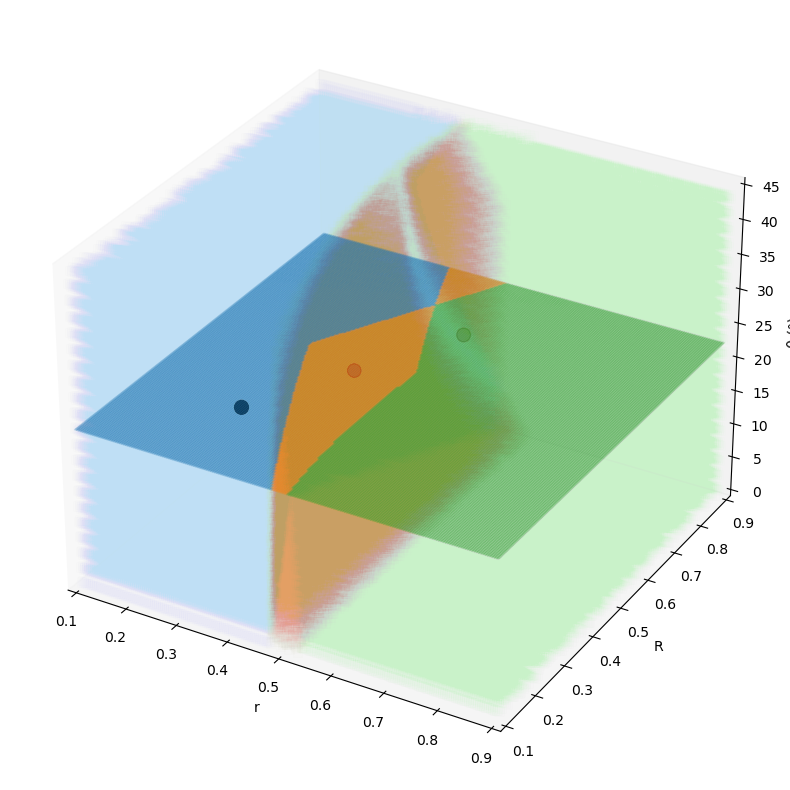

In [22]:
# Square system
import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rl_range = np.linspace(0.10, 0.90, 200)
Rl_range = np.linspace(0.10, 0.90, 200)
theta_range = np.linspace(0, 45, 200)
rr, RR, tt = np.meshgrid(rl_range, Rl_range, theta_range)
data_file = Path("subfigs-Fig6") / "dimensionality-200-square.npy"
if not data_file.exists():
    dm = []
    for r_, R_, t_ in tqdm(zip(rr.flatten(), RR.flatten(), tt.flatten()), total=rr.flatten().size):
        dm.append(pattern_dimensionality(r_, R_, t_))
    dm = np.array(dm)
    np.save(data_file, dm)
else:
    dm = np.load(data_file)
ddmm = np.reshape(dm, rr.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ["w", "r", "gray"]
colors = ['#bfdff5', '#e39f64', '#c9f2c9']

rr_0d = rr[ddmm == 0]
RR_0d = RR[ddmm == 0]
tt_0d = tt[ddmm == 0]
dm_0d = dm[dm == 0]

rr_1d = rr[ddmm == 1]
RR_1d = RR[ddmm == 1]
tt_1d = tt[ddmm == 1]
dm_1d = dm[dm == 1]

rr_2d = rr[ddmm == 2]
RR_2d = RR[ddmm == 2]
tt_2d = tt[ddmm == 2]
dm_2d = dm[dm == 2]

points_1d = np.column_stack((rr_1d, RR_1d, tt_1d))

# Half of z-max
index = 99
z_height = tt[0, 0, index]
zz = np.ones(rr[:, :, index].shape) * z_height
fc = plt.cm.tab10(ddmm[:, :, index])
# transparent face color, explicit
fc[:, :, -1] = 0.2
ax.plot_surface(rr[:, :, index], RR[:, :, index], zz, 
                rstride=1, 
                cstride=1, 
                facecolors=fc, 
                shade=False)

scatter = ax.scatter(rr_1d[::10], RR_1d[::10], tt_1d[::10], 
                     s=45,
                     color=colors[1], alpha=0.008, marker='s')
scatter = ax.scatter(rr_0d[::10], RR_0d[::10], tt_0d[::10], 
                     s=45,
                     color=colors[0], alpha=0.002, marker='s')
scatter = ax.scatter(rr_2d[::10], RR_2d[::10], tt_2d[::10], 
                     s=45,
                     color=colors[2], alpha=0.002, marker='s')

dots = np.array([(0.3, 0.3, z_height),
       (0.4, 0.5, z_height),
       (0.5, 0.7, z_height)])

ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], s=100, color="k", marker="o")

ax.set_xlim(0.1, 0.9)
ax.set_ylim(0.1, 0.9)
ax.set_zlim(0, 45)

ax.set_xlabel("r")
ax.set_ylabel("R")
ax.set_zlabel("θ (°)")
ax.grid(False)
fig.tight_layout()
fig.savefig("subfigs-Fig6/3d_phase_diagram_square.png")

A similar phase diagram for hexagonal lattice is plot using slightly coarser mesh (100 in each direction)

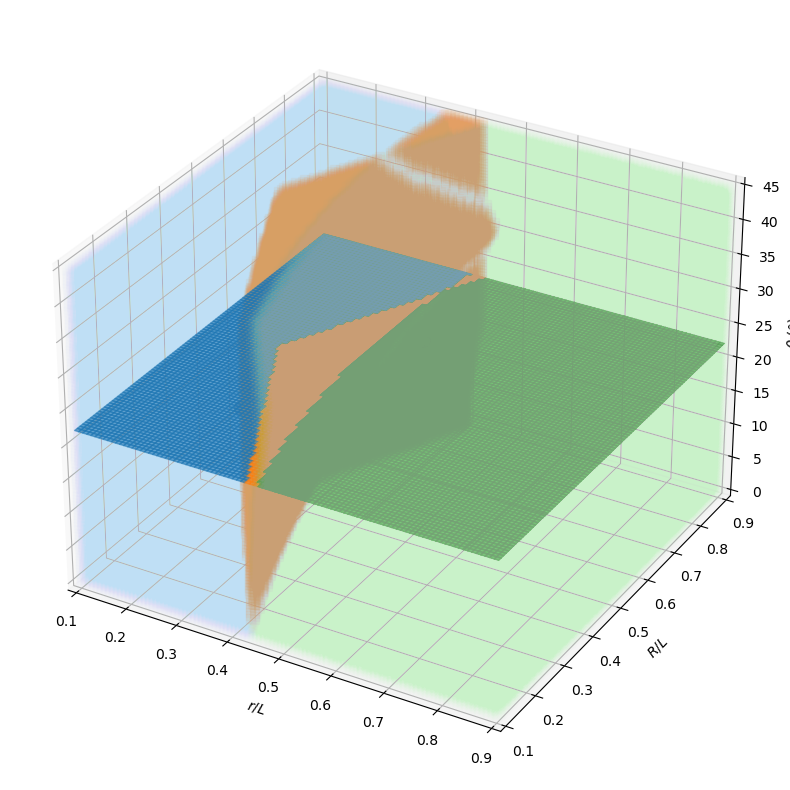

In [24]:
import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rl_range = np.linspace(0.10, 0.90, 100)
Rl_range = np.linspace(0.10, 0.90, 100)
theta_range = np.linspace(0, 45, 100)
rr, RR, tt = np.meshgrid(rl_range, Rl_range, theta_range)
dm = []
data_file = Path("subfigs-Fig6") / "dimensionality-100-hex.npy"
if not data_file.exists():
    for r_, R_, t_ in tqdm(zip(rr.flatten(), RR.flatten(), tt.flatten()), total=rr.flatten().size):
        dm.append(pattern_dimensionality(r_, R_, t_, lattice="hex"))
    dm = np.array(dm)
    np.save(data_file, dm)
else:
    dm = np.load(data_file)
ddmm = np.reshape(dm, rr.shape)



fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ["w", "r", "gray"]
colors = ['#bfdff5', '#e39f64', '#c9f2c9']

rr_0d = rr[ddmm == 0]
RR_0d = RR[ddmm == 0]
tt_0d = tt[ddmm == 0]
dm_0d = dm[dm == 0]

rr_1d = rr[ddmm == 1]
RR_1d = RR[ddmm == 1]
tt_1d = tt[ddmm == 1]
dm_1d = dm[dm == 1]

rr_2d = rr[ddmm == 2]
RR_2d = RR[ddmm == 2]
tt_2d = tt[ddmm == 2]
dm_2d = dm[dm == 2]

points_1d = np.column_stack((rr_1d, RR_1d, tt_1d))

# Half of z-max
index = 49
z_height = tt[0, 0, index]
zz = np.ones(rr[:, :, index].shape) * z_height
fc = plt.cm.tab10(ddmm[:, :, index])
# transparent face color, explicit
fc[:, :, -1] = 0.6
ax.plot_surface(rr[:, :, index], RR[:, :, index], zz, 
                rstride=1, 
                cstride=1, 
                facecolors=fc, 
                shade=False)

scatter = ax.scatter(rr_1d, RR_1d, tt_1d, 
                     s=45,
                     # c=dm_1d, 
                     color=colors[1], alpha=0.08, marker='s')
scatter = ax.scatter(rr_0d, RR_0d, tt_0d, 
                     s=45,
                     # c=dm_1d, 
                     color=colors[0], alpha=0.02, marker='s')
scatter = ax.scatter(rr_2d, RR_2d, tt_2d, 
                     s=45,
                     # c=dm_1d, 
                     color=colors[2], alpha=0.01, marker='s')

dots = np.array([(0.3, 0.3, z_height),
       (0.35, 0.55, z_height),
       (0.45, 0.65, z_height)])

ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], s=100, color="k", marker="o")

ax.set_xlim(0.1, 0.9)
ax.set_ylim(0.1, 0.9)
ax.set_zlim(0, 45)

ax.set_xlabel("$r/L$")
ax.set_ylabel("$R/L$")
ax.set_zlabel("$\\theta$ (°)")

fig.tight_layout()
plt.savefig("subfigs-Fig6/3d_phase_diagram_hex.png", dpi=300)

##### 